In [144]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold, SelectFromModel
from skfeature.function.similarity_based import fisher_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Notebook parameters

In [145]:
# notebook parameters

input_dataset_path = "data/heart_disease_health_indicators_BRFSS2015.csv"
target_col = "HeartDiseaseorAttack"
separator = ','
generate_new_folds = False
n_splits = 5
k_best_features = 5

fix_imbalanced_dataset = False
use_oversampling = False
use_undersampling = False

### 1. Load dataset

In [146]:
heart_df = pd.read_csv(input_dataset_path, sep=separator)
heart_df.drop(columns=[col for col in heart_df.columns if col.lower()=='id'], inplace=True)
if all(isinstance(item, (int, float, np.int32, np.int64)) for item in list(heart_df[target_col].unique())):
    heart_df[target_col] = heart_df[target_col].astype(int)
heart_df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


#### 1.1 Check if there are NaN values present in the dataset

In [147]:
assert heart_df[heart_df.isna().any(axis=1)].empty, 'Dataset contains NaN values!'

#### 1.2 Get infromation about dataset shape and target values

In [148]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=[target_col]).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df[target_col].unique()}")
print(f"Number of classes in target: {heart_df[target_col].unique().shape[0]}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 253680 rows and 22 colums
Input dataset consists of 21 features and 1 target column
Target values are: [0 1]
Number of classes in target: 2
Input dataset contains 23899 duplicated rows and 229781 unique rows


#### 1.3 Check if the target is balanced - the target value distribution

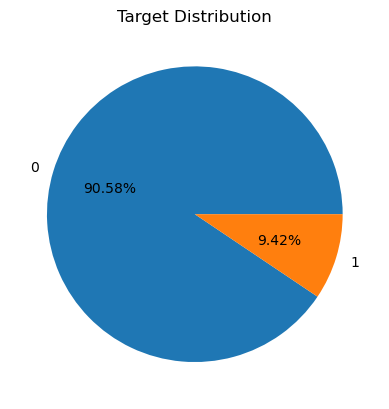

In [149]:
plt.pie(x=heart_df[target_col].value_counts().values,labels=heart_df[target_col].unique().tolist(),autopct='%1.2f%%')
plt.title('Target Distribution')
plt.show()

#### 1.4 Print features correlation matrix

<Axes: >

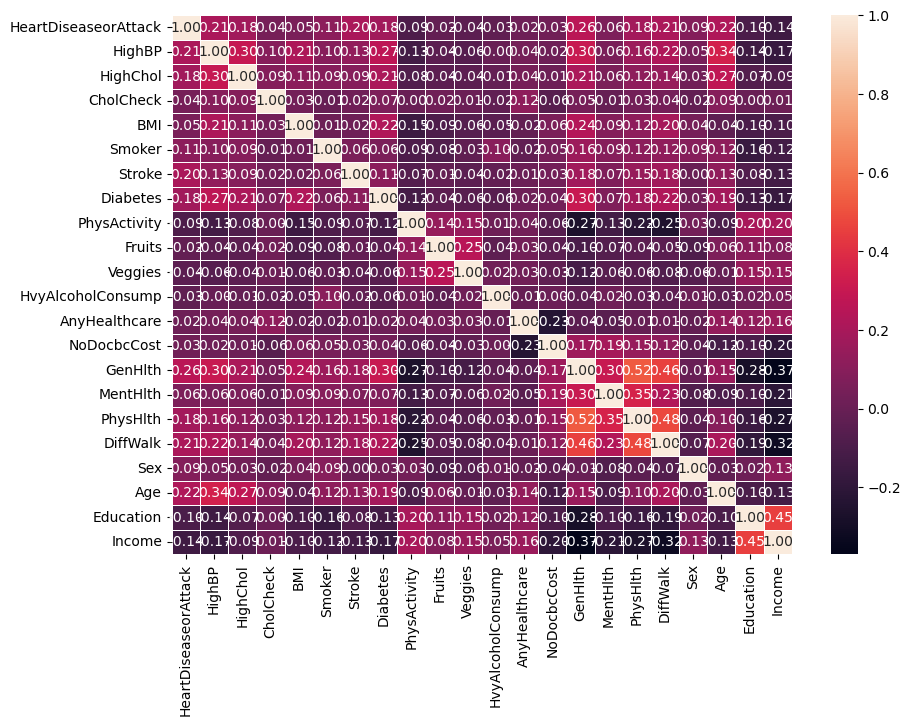

In [150]:
corr_matrix = heart_df.corr()
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5, ax=ax)

In [151]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  int32  
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [152]:
dfSummary(heart_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,HeartDiseaseorAttack[int32],1. 02. 1,"229,787 (90.6%)23,893 (9.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bQWrDMBRF0a9iQjKRMAYvxovIYrsI7cYYa9CETNRB5yGW3JfWumdu+IOLIcHP5ZwNUHBmdjGz07sPwb/xyDnfSh7shmG4eu/7vS/CMaWUFufcZ0lwnfe+n6bpFkK4/8ZxOI51Xc8xxn6e55OZbY/NzCyEcB/H8Wv363BEl9IHP/a8AniG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmc7s56O4dx+Cv6+2ky6ltMQYe6v4KA7tSCktZvYoeZbBC7YqHrw4pnxQqX2zFVeO9lRN+WpmXWhP8ZSvdtaF9tRO+fgFi5fxpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCme8jH/w1ZVU76aWRfaw+AFMt8KW2rfOfaTaQAAAABJRU5ErkJggg=="">",0(0.0%)
2,HighBP[float64],1. 0.02. 1.0,"144,851 (57.1%)108,829 (42.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bQWrDMBhE4VExodlIGIMP40P0sD2EbmOMtWhCNuqiAZ9Ao2K/7wR/wsOQ4Am1VgEOQdJd0q33ISf3qrU+eh/R2zBN01eMcex9yJmVUrYQwvfVgxtijOOyLI+U0rP3MWe07/tnznlc1/Um6dqxSVJK6TnP80/vY07s3vuA/+Cj9wG4DmKDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2wG6e8Fv96HnBXf7WEopWw551G84NdMKWWT9Op9R28MXjwYvEgKTPngwpPtwNOnMaZ8b8zt2mPKJ+Z2Lkz5Dvwab4w/dWFDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDVM+8fldmPK9Mbdrj8HLgcFLY78KW2rfLYfn7QAAAABJRU5ErkJggg=="">",0(0.0%)
3,HighChol[float64],1. 0.02. 1.0,"146,089 (57.6%)107,591 (42.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bQWrDMBhE4VExodlIGIMP40P0sD2EbmOMtWhCNuqiAZ9Ao2K/7wR/wsOQ4Am1VgEOQdJd0q33ISf3qrU+eh/R2zBN01eMcex9yJmVUrYQwvfVgxtijOOyLI+U0rP3MWe07/tnznlc1/Um6dqxSVJK6TnP80/vY07s3vuA/+Cj9wG4DmKDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2wG6e8Fv96HnBXf7WEopWw551G84NdMKWWT9Op9R28MXjwYvEgKTPngwpPtwNOnMaZ8b8zt2mPKJ+Z2Lkz5Dvwab4w/dWFDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDVM+8fldmPK9Mbdrj8HLgcFLY78KW2rfLYfn7QAAAABJRU5ErkJggg=="">",0(0.0%)
4,CholCheck[float64],1. 1.02. 0.0,"244,210 (96.3%)9,470 (3.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bMWrDMBiG4V/FhGaRMAYfxofoYXsI3cYYa2hCFnXoVGMZYppPoL7P6OkfXgwJ/lzO2QAFZ2ZXM7vUPgRNeeScb9uH3TAMH977vsZFaFNKaXHOfW6D67z3/TRNtxDCvdZxaMe6ru8xxn6e54uZ/Y7NzCyEcB/H8avKdWjRde/hm/oK/F/EBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIdGY/H7zVPgRtOGqpSyktMcbeCh+8Ac9KKS1m9tg+Z/CCV9gdvDimfFA5erPt1gmcVZzyleZYwFm7U76jORZw1tGUj1+n+FP8qQsZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZHanfEz78ArFKV9pjgWcxeAFMt8KW2rfzqzdbgAAAABJRU5ErkJggg=="">",0(0.0%)
5,BMI[float64],Mean (sd) : 28.4 (6.6)min < med < max:12.0 < 27.0 < 98.0IQR (CV) : 7.0 (4.3),84 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACVklEQVR4nO3dMY7aQBiG4X/CggwoY1mWoOMCkVJQ+hB72LTpUnACbkCDkBAY4cXBGKdKmSy2IfHHvk8/sxa88mKkn3FVVRnQdZ/+9wUAt3h55ObOuaGZDVpsca6q6nSv64Guh4XqnBvGcfzqvY+a7nE4HHbOuW/EikfeUQfe+yhJklMYhnndxWmaBovFItputwMzI9QP7qH/+s3MwjDMJ5PJW8Plw7teDGTxMAUJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJD//F6TbKsuybmXfONVnOQRVPpLOhZlnWL4ri62w26/V6vdpnAHBQxXPpbKjn8/klCILRfD7Pp9Pprs5aDqp4Pp0N9bfxeNz0sAoOqngiPExBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCQudnpppqOWptxrh1p7wbqnNuaGaDBnv76/Xab7Cutbaj1maMW3fNX0N1zg3jOH713kd1Ny6KIijL8kue5z/MrMkUaWNtRq3NGLfuovfuqAPvfZQkySkMw1p3ptVqFS2Xy9Hlcum1uL5WWoxamzFu3Sk3fUYNw7D2G77b7XijcT

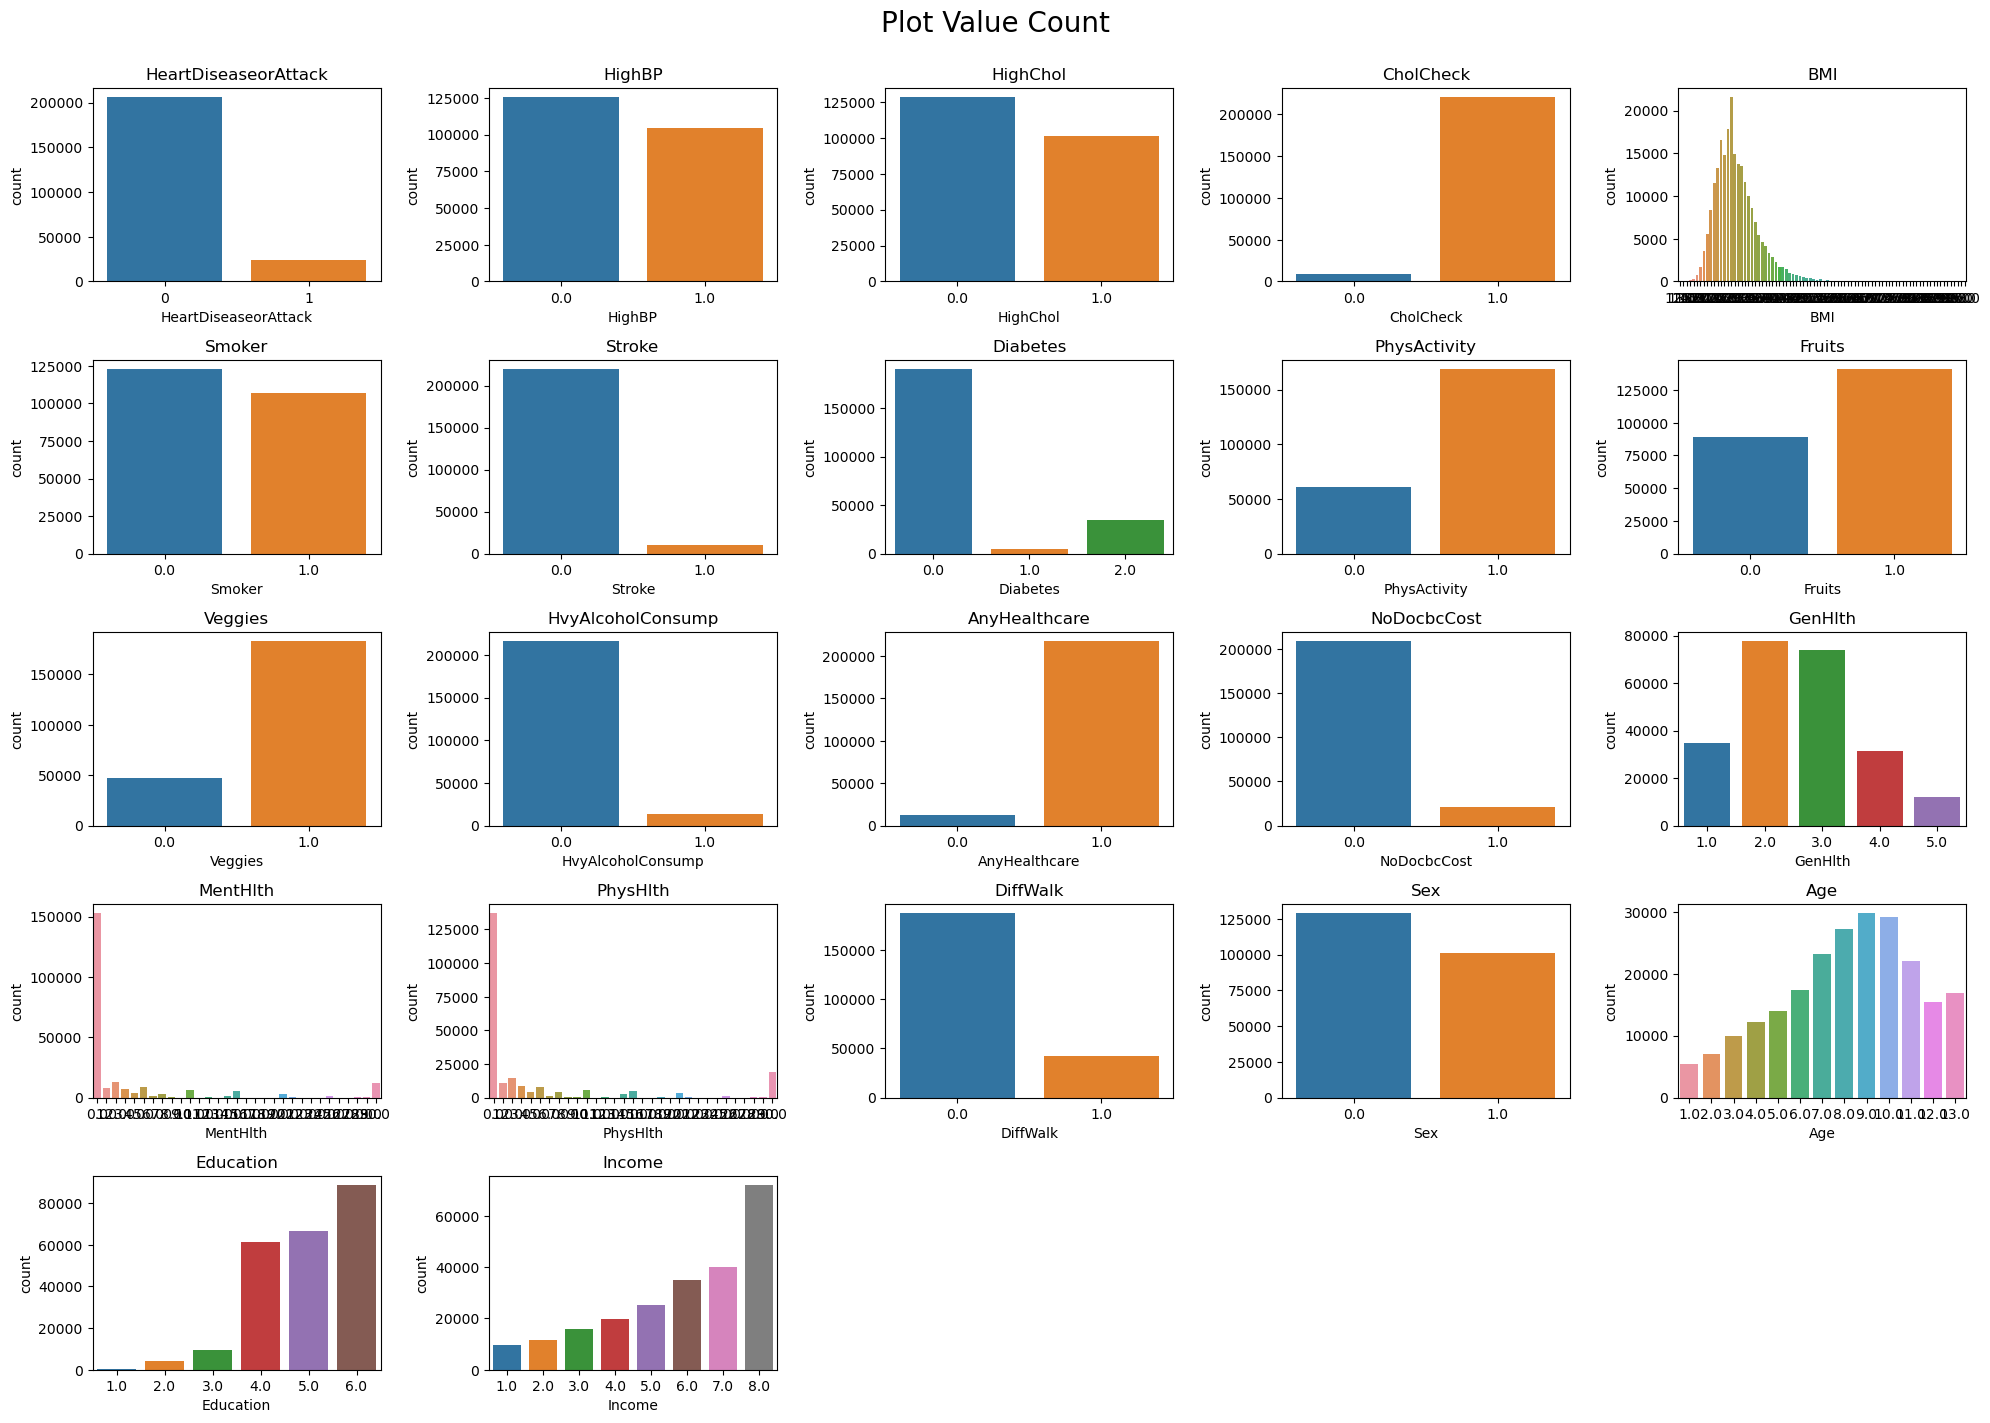

In [199]:
# Countplot on each feature
plt.figure(figsize=(20,60))
for i,column in enumerate(heart_df.columns):
    plt.subplot(len(heart_df.columns), 5, i+1)
    plt.suptitle("Plot Value Count", fontsize=20, x=0.5, y=1)
    sns.countplot(data=heart_df, x=column)
    plt.title(f"{column}")
    plt.tight_layout()

In [200]:
bin_features = ['HighBP', 'HighChol', 'CholCheck','Smoker', 'Stroke','PhysActivity', 'Fruits', 'Veggies', 
                'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
cat_features = ['Diabetes', 'GenHlth', 'Education','Income']
num_features = ['BMI','MentHlth', 'PhysHlth', 'Age']

(229781, 22)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


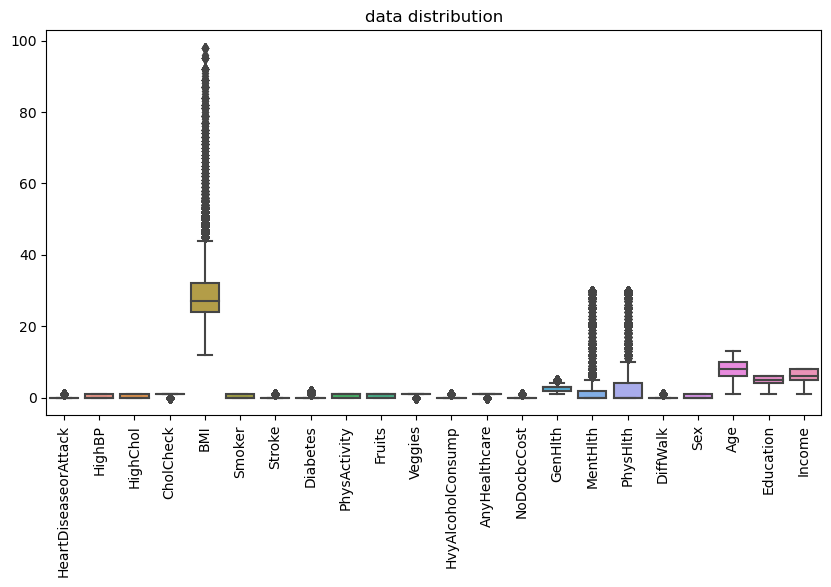

In [198]:
plt.figure(figsize=(10,5))
sns.boxplot(heart_df)
print(heart_df.shape)
l=list(np.arange(22))
print(l)
plt.title("data distribution")
plt.xticks(l, list(heart_df.columns),
       rotation=90)
plt.show()

### 2. Preprocess dataset

#### 2.1 Drop duplicated values and separate features from target

In [153]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

#### 2.2 Encode columns tahat have categorical data with LabelEncoder

In [154]:
label_encoders = {}

# Iterate through columns with categorical data
for column in heart_df.columns:
    if heart_df[column].dtype == 'object':
        le = LabelEncoder()
        heart_df[column] = le.fit_transform(heart_df[column])
        label_encoders[column] = le
        print(f'{column} was encoded')

In [155]:
# # Decode the encoded data
# decoded_heart_df = pd.DataFrame()
# for column in heart_df.columns:
#     if column in label_encoders:
#         decoded_values = label_encoders[column].inverse_transform(heart_df[column])
#         decoded_heart_df[column] = decoded_values
#     else:
#         decoded_heart_df[column] = heart_df[column]

#### 2.3 Separate features from target

In [156]:
# divide a heart failure dataset into features and target value sets
X = heart_df.drop(columns=[target_col])
y = heart_df[target_col]

### 3. Divide dataset into startified training and testing set (20%)

In [157]:
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

### 4. Detect important features for feature selection

#### 4.1 Removal of all feature with low variance (threshold = 0.005)

In [158]:
vthresh = VarianceThreshold(threshold=0.005)
vthresh.fit_transform(X_train)
selected_features_vth = vthresh.get_feature_names_out()
print(f'Variance Threshold (0.005) selected features are: {selected_features_vth}')

Variance Threshold (0.005) selected features are: ['HighBP' 'HighChol' 'CholCheck' 'BMI' 'Smoker' 'Stroke' 'Diabetes'
 'PhysActivity' 'Fruits' 'Veggies' 'HvyAlcoholConsump' 'AnyHealthcare'
 'NoDocbcCost' 'GenHlth' 'MentHlth' 'PhysHlth' 'DiffWalk' 'Sex' 'Age'
 'Education' 'Income']


#### 4.2 Chi2 test to define important features with alpha = 0.05

In [159]:
alpha = 0.05
f_score, p_values = chi2(X_train, y_train)
p_values = pd.Series(p_values)
p_values.index = X_train.columns
p_values.sort_values(ascending=False, inplace=True)
selected_features_chi2 = list(p_values[p_values < alpha].index)
print(f'Chi2 test selected features are: {selected_features_chi2}')

Chi2 test selected features are: ['AnyHealthcare', 'CholCheck', 'Veggies', 'NoDocbcCost', 'HvyAlcoholConsump', 'Education', 'PhysActivity', 'BMI', 'Sex', 'Smoker', 'PhysHlth', 'Age', 'DiffWalk', 'HighBP', 'MentHlth', 'GenHlth', 'HighChol', 'Diabetes', 'Stroke', 'Income']


#### 4.3 Information gain - estimate mutual information with threshold 0.05

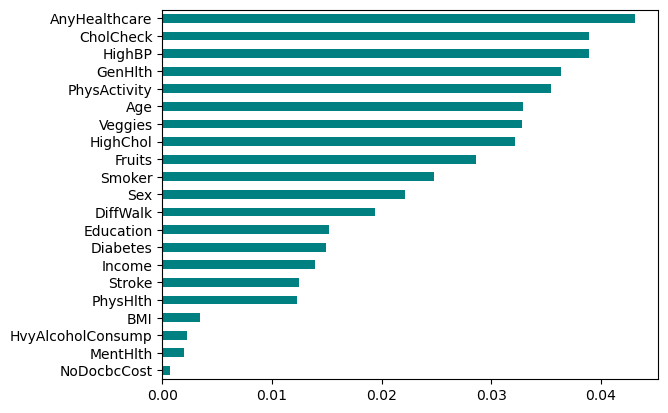

In [160]:
importances = mutual_info_classif(X_train,y_train)
feat_importances = pd.Series(importances, X_train.columns).sort_values()
feat_importances.plot(kind='barh', color='teal')
plt.show()

In [161]:
threshold = 0.01
selected_features_mi = list(feat_importances[feat_importances > threshold].index)
print(f'Mutual infromation estimation selected features are: {selected_features_mi}')

Mutual infromation estimation selected features are: ['PhysHlth', 'Stroke', 'Income', 'Diabetes', 'Education', 'DiffWalk', 'Sex', 'Smoker', 'Fruits', 'HighChol', 'Veggies', 'Age', 'PhysActivity', 'GenHlth', 'HighBP', 'CholCheck', 'AnyHealthcare']


#### 4.4 Correlation based feature selection with threshold 0.8

In [162]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

high_corr_features = set(correlation(X_train, 0.8))
selected_features_corr = [item for item in X_train.columns if item not in high_corr_features]
print(f'Pearson correlation selected features are: {selected_features_corr}')

Pearson correlation selected features are: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### 4.5 Mean Absolute Difference (MAD) feature selection - works better for continuous / numerical data 

In [163]:
# mean_abs_diff = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0) / X_train.shape[0]
# mad_feat_importances = pd.Series(mean_abs_diff, X_train.columns).sort_values()
# mad_feat_importances.plot(kind='barh', color='teal')
# plt.show()

In [164]:
# threshold = 0.5
# selected_features_mad = list(mad_feat_importances[mad_feat_importances > threshold].index)
# print(f'Mean Absolute Difference selected features are: {selected_features_mad}')

#### 4.6 LASSO Regularization (L1) feature selection embedded method

In [165]:
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=7).fit(X_train, y_train)
sfm = SelectFromModel(logistic, prefit=True)

X_train_new = sfm.transform(X_train)
l1_scores = pd.DataFrame(X_train_new, columns=X_train.columns).var()
selected_features_l1 = list(l1_scores[l1_scores != 0].index)
print(f'Lasso L1 Regularization selected features are: {selected_features_l1}')

Lasso L1 Regularization selected features are: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### 4.7 Important features that were selected across all methods

In [166]:
vrh_sf = set(selected_features_vth)
chi2_sf = set(selected_features_chi2)
mi_sf = set(selected_features_mi)
corr_sf = set(selected_features_corr)
l1_sf = set(selected_features_l1)

common_features = list(vrh_sf.intersection(chi2_sf, mi_sf, corr_sf, l1_sf))
print(f'Across all methods there were {len(common_features)} selected. These are: {common_features}')

Across all methods there were 16 selected. These are: ['Sex', 'AnyHealthcare', 'Age', 'Stroke', 'Diabetes', 'Veggies', 'HighChol', 'CholCheck', 'GenHlth', 'Education', 'PhysActivity', 'PhysHlth', 'Income', 'DiffWalk', 'HighBP', 'Smoker']


### 5. Modeling

#### 5.1 Initialize base classifiers

In [175]:
clf1 = LogisticRegression(multi_class='multinomial',
                          solver='newton-cg',
                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = DecisionTreeClassifier(random_state=1)
clf4 = SVC(kernel="linear", C=0.3, random_state=1)
clf5 = RandomForestClassifier(random_state=1)
clf6 = XGBClassifier(objective= 'binary:logistic',
                    nthread=4,
                    seed=42)
clf7 = GaussianNB()
clf8 = NearestCentroid(metric='euclidean', shrink_threshold=0.5)

In [176]:
if fix_imbalanced_dataset and use_oversampling:
    sampler = SMOTE(random_state=42)
elif fix_imbalanced_dataset and use_undersampling:
    sampler = RandomUnderSampler(random_state=42)

#### 5.2 Build pipelines with respected models

In [177]:
if fix_imbalanced_dataset:
    pipe1 = Pipeline([('scaler', StandardScaler()),
                    ('sampler', sampler),
                    ('LR', clf1)])

    pipe2 = Pipeline([('scaler', StandardScaler()),
                    ('sampler', sampler),
                    ('KNN', clf2)])
    
    pipe3 = Pipeline([('sampler', sampler),
                    ('DT', clf3)])

    pipe4 = Pipeline([('scaler', StandardScaler()),
                    ('sampler', sampler),
                    ('SVM', clf4)])
    
    pipe5 = Pipeline([('sampler', sampler),
                    ('RF', clf5)])

    pipe6 = Pipeline([('sampler', sampler),
                    ('XGB', clf6)])

    pipe7 = Pipeline([('scaler', StandardScaler()),
                    ('sampler', sampler),
                    ('GNB', clf7)])

    pipe8 = Pipeline([('scaler', StandardScaler()),
                    ('sampler', sampler),
                    ('NC', clf8)])

else:
    # Building the pipelines based on pre defined classifiers
    pipe1 = Pipeline([('scaler', StandardScaler()),
                    ('LR', clf1)])

    pipe2 = Pipeline([('scaler', StandardScaler()),
                    ('KNN', clf2)])

    pipe4 = Pipeline([('scaler', StandardScaler()),
                    ('SVM', clf4)])

    pipe7 = Pipeline([('scaler', StandardScaler()),
                    ('GNB', clf7)])

    pipe8 = Pipeline([('scaler', StandardScaler()),
                    ('NC', clf8)])

#### 5.3 Set up parameter grids for GridSearchCV hyperparameter tuning

In [170]:
# Logistic Regression parameters
param_grid1 = [{'LR__penalty': ['l1', 'l2'],
                'LR__C': np.power(10., np.arange(-4, 4))}]

# KNN parameters
param_grid2 = [{'KNN__n_neighbors': list(range(1, 10)),
                'KNN__p': [1, 2]}]

# Decision Trees parameters
param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

# SVM parameters
param_grid4 = [{'SVM__kernel': ['rbf'],
                'SVM__C': np.power(10., np.arange(-4, 4)),
                'SVM__gamma': np.power(10., np.arange(-5, 0))},
               {'SVM__kernel': ['linear'],
                'SVM__C': np.power(10., np.arange(-4, 4))}]

# Random Forest parameters
param_grid5 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

# XGBoost parameters
param_grid6 = [{'XGB__max_depth': range (2, 10, 1),
               'XGB__n_estimators': range(60, 220, 40),
               'XGB__learning_rate': [0.1, 0.01, 0.05]}]

# Gausian Naive Bayes parameters
param_grid7 = [{'GNB__var_smoothing': np.logspace(0,-9, num=100)}]

# Nearest Centraid parameters
param_grid8 = [{'NC__shrink_threshold': np.arange(0, 1.01, 0.01),
                'NC__metric': ['euclidean', 'manhattan']}]


In [171]:
# scoring = {
#     'accuracy' : make_scorer(accuracy_score), 
#     'precision' : make_scorer(precision_score),
#     'recall' : make_scorer(recall_score), 
#     'f1_score' : make_scorer(f1_score),
#     'mcc': make_scorer(matthews_corrcoef),
#     'roc_auc_score': make_scorer(roc_auc_score)
# }

#### 5.4. Set up multiple GridSearchCV objects, 1 for each algorithm

In [182]:
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid6),
                            (pipe1, clf6),
                            ('LR', 'aXGB')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                    #    scoring='accuracy',
                    #    scoring=scoring,
                       scoring='f1',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

#### 5.5 Tarin models and find best parameters

In [183]:
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Classification algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):

        gridcvs[name].fit(X_train[common_features].iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        print('\n        Best F1 score (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train[common_features].iloc[valid_idx], y_train.iloc[valid_idx]))
        print('        F1 score (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        F1 score %.2f%% +/- %.2f' % (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

-------------------------------------------------- 

Classification algorithm: LR
    Inner loop:


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\pipeline.py", line 420, in fit


        Best F1 score (avg. of inner test folds) 20.47%
        Best parameters: {'LR__C': 10.0, 'LR__penalty': 'l2'}
        F1 score (on outer test fold) 89.90%


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\pipeline.py", line 420, in fit


        Best F1 score (avg. of inner test folds) 20.29%
        Best parameters: {'LR__C': 1.0, 'LR__penalty': 'l2'}
        F1 score (on outer test fold) 89.91%


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\pipeline.py", line 420, in fit


        Best F1 score (avg. of inner test folds) 20.10%
        Best parameters: {'LR__C': 1.0, 'LR__penalty': 'l2'}
        F1 score (on outer test fold) 89.94%


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-pa


        Best F1 score (avg. of inner test folds) 20.82%
        Best parameters: {'LR__C': 10.0, 'LR__penalty': 'l2'}
        F1 score (on outer test fold) 89.89%


c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pklimanek\Anaconda3\envs\magisterka\lib\site-packages\sklearn\pipeline.py", line 420, in fit


        Best F1 score (avg. of inner test folds) 20.20%
        Best parameters: {'LR__C': 1.0, 'LR__penalty': 'l2'}
        F1 score (on outer test fold) 89.99%

    Outer Loop:
        F1 score 89.92% +/- 0.04
-------------------------------------------------- 

Classification algorithm: aXGB
    Inner loop:
[16:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "XGB__learning_rate", "XGB__max_depth", "XGB__n_estimators" } are not used.


        Best F1 score (avg. of inner test folds) 20.31%
        Best parameters: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 2, 'XGB__n_estimators': 60}
        F1 score (on outer test fold) 89.84%
[17:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "XGB__learning_rate", "XGB__max_depth", "XGB__n_estimators" } are not

### 6. Best model training

In [187]:
gcv_model_select = GridSearchCV(estimator=clf6,
                                param_grid=param_grid6,
                                scoring='f1',
                                n_jobs=-1,
                                cv=outer_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train[common_features], y_train)
print('Best CV F1 score: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[19:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "XGB__learning_rate", "XGB__max_depth", "XGB__n_estimators" } are not used.

Best CV F1 score: 19.30%
Best parameters: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 2, 'XGB__n_estimators': 60}


### 7. Best model evaluation

In [195]:
## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# gcv_model_select.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=gcv_model_select.predict(X_train[common_features]))
test_acc = accuracy_score(y_true=y_test, y_pred=gcv_model_select.predict(X_test[common_features]))

train_recall = recall_score(y_true=y_train, y_pred=gcv_model_select.predict(X_train[common_features]))
test_recall = recall_score(y_true=y_test, y_pred=gcv_model_select.predict(X_test[common_features]))

train_precision = precision_score(y_true=y_train, y_pred=gcv_model_select.predict(X_train[common_features]))
test_precision = precision_score(y_true=y_test, y_pred=gcv_model_select.predict(X_test[common_features]))

train_f1 = f1_score(y_true=y_train, y_pred=gcv_model_select.predict(X_train[common_features]))
test_f1 = f1_score(y_true=y_test, y_pred=gcv_model_select.predict(X_test[common_features]))

tarin_mcc = matthews_corrcoef(y_true=y_train, y_pred=gcv_model_select.predict(X_train[common_features]))
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=gcv_model_select.predict(X_test[common_features]))

tarin_roc_auc = roc_auc_score(y_true=y_train, y_score=gcv_model_select.predict(X_train[common_features]))
test_roc_auc = roc_auc_score(y_true=y_test, y_score=gcv_model_select.predict(X_test[common_features]))

train_scores = {
    'ACC': train_acc,
    'Recall': train_recall,
    'Precision': train_precision,
    'F1 score': train_f1,
    'MCC': tarin_mcc,
    'ROC AUC score': tarin_roc_auc
}

train_scores_df = pd.DataFrame(list(train_scores.items()), columns=['Metric name', 'Metric value'])
train_scores_df['Dataset'] = 'training'

test_scores = {
    'ACC': test_acc,
    'Recall': test_recall,
    'Precision': test_precision,
    'F1 score': test_f1,
    'MCC': test_mcc,
    'ROC AUC score': test_roc_auc
}

test_scores_df = pd.DataFrame(list(test_scores.items()), columns=['Metric name', 'Metric value'])
test_scores_df['Dataset'] = 'testing'

model_scores_df = pd.concat([train_scores_df, test_scores_df], axis=0)

# print('Training Accuracy: %.2f%%' % (100 * train_acc))
# print('Test Accuracy: %.2f%%' % (100 * test_acc))

In [196]:
model_scores_df

,Metric name,Metric value,Dataset
0,ACC,0.904866,training
1,Recall,0.146885,training
2,Precision,0.681751,training
3,F1 score,0.241696,training
4,MCC,0.286777,training
5,ROC AUC score,0.569497,training
0,ACC,0.897295,testing
1,Recall,0.108159,testing
2,Precision,0.511466,testing
3,F1 score,0.178559,testing


### 8. Save trained best model into pickle

In [190]:
import pickle
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

with open(f'models/best_model_{timestamp}.pickle', 'wb') as file:
    pickle.dump(gcv_model_select, file)

In [194]:
import openpyxl

model_scores_df.to_excel(f'models/best_model_results_{timestamp}.xlsx', index=False, header=True)